In [6]:
# 멀티모달 예제 2: 이미지 기반 질문-답변 시스템
# CLIP으로 이미지 특징을 추출하고, LLM이 사용자 질문에 답변합니다.

# 필요한 라이브러리 설치
!pip install transformers torch torchvision pillow requests matplotlib openai-clip

In [ ]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf



import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import requests
import matplotlib.pyplot as plt
import io
import clip
import numpy as np
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import warnings
warnings.filterwarnings('ignore')

import matplotlib.font_manager as fm

# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

### OpenAI의 CLIP 모델 중 "ViT-B/32" 아키텍처 

clip.load("ViT-B/32", device=self.device)

"ViT-B/32": CLIP 모델 중 Vision Transformer(기반) 모델로,
"ViT"는 Vision Transformer의 약자. "B"는 'base' 규모,
"32"는 패치 크기(patch size 32x32)를 의미합니다.

반환값이 tuple :

self.model: 이미지와 텍스트를 임베딩 벡터로 변환하고, 두 벡터의 유사도를 계산하는 CLIP 모델 객체입니다.
즉, 이미지/텍스트 쌍의 의미적 유사도를 뽑아낼 때 사용합니다.

self.preprocess:
CLIP에서 요구하는, 입력 이미지를 전처리(정규화, 리사이징 등)하는 함수입니다.
PIL 이미지 형식 등에서 바로 모델 입력 텐서로 변환해줍니다.

### BLIP(Bootstrapped Language-Image Pretraining)
BLIP(Bootstrapped Language-Image Pretraining) 이미지 캡셔닝 모델

##  CLIP 으로 이미지와 텍스트의 유사도 계산

코드 분해 설명

  similarity = (100.0 * image_features @
  text_features.T).softmax(dim=-1)

  1. image_features @ text_features.T

  - @: 행렬 곱셈 연산자 (matrix multiplication)
  - image_features: 이미지 특징 벡터 (shape: [batch_size, feature_dim])
  - text_features.T: 텍스트 특징 벡터의 전치행렬 (shape: [feature_dim,
  num_texts])
  - 결과: 코사인 유사도 행렬 (shape: [batch_size, num_texts])

  2. 100.0 *

  - Temperature scaling (온도 스케일링)
  - 유사도 값을 100배로 증폭하여 softmax 함수의 민감도를 높임
  - 작은 차이도 더 큰 확률 차이로 변환됨

  3. .softmax(dim=-1)

  - 마지막 차원(텍스트 방향)에 대해 softmax 적용
  - 각 이미지에 대해 모든 텍스트와의 확률 분포로 변환
  - 결과: 각 행의 합이 1인 확률 행렬

  구체적 예시

  ### 예시 데이터
  image_features = torch.tensor([[0.1, 0.2, 0.3],    # 이미지1 특징
                                 [0.4, 0.5, 0.6]])    # 이미지2 특징

  text_features = torch.tensor([[0.1, 0.3, 0.2],     # 텍스트1 특징
                                [0.2, 0.1, 0.4],     # 텍스트2 특징
                                [0.3, 0.2, 0.1]])    # 텍스트3 특징

   1단계: 행렬 곱셈
  dot_product = image_features @ text_features.T
   결과: [[0.14, 0.17, 0.10],  # 이미지1과 각 텍스트의 내적
          [0.41, 0.37, 0.28]]  # 이미지2와 각 텍스트의 내적

   2단계: Temperature scaling
  scaled = 100.0 * dot_product
   결과: [[14.0, 17.0, 10.0],
          [41.0, 37.0, 28.0]]

   3단계: Softmax
  similarity = scaled.softmax(dim=-1)
   결과: [[0.18, 0.67, 0.15],  # 이미지1이 각 텍스트와 유사할 확률
          [0.67, 0.24, 0.09]]  # 이미지2가 각 텍스트와 유사할 확률

  핵심 의미

  - 각 이미지가 어떤 텍스트 설명과 가장 잘 맞는지를 확률로 표현
  - 높은 값일수록 해당 이미지-텍스트 쌍이 더 유사함
  - Zero-shot 분류나 이미지 검

In [8]:


class ImageFeatureExtractor:
    """CLIP 기반 이미지 특징 추출기"""

    def __init__(self):
        # CLIP 모델 로드
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"🖥️ 사용 중인 디바이스: {self.device}")

        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)

        # 이미지 캡션 생성을 위한 BLIP 모델
        self.caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        self.caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    def extract_features(self, image):
        """이미지에서 특징 벡터 추출"""
        # 이미지 전처리
        image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)

        # CLIP으로 특징 추출
        with torch.no_grad():
            image_features = self.model.encode_image(image_tensor)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        return image_features.cpu().numpy()

    def generate_caption(self, image):
        """이미지 캡션 생성"""
        # BLIP으로 캡션 생성
        inputs = self.caption_processor(image, return_tensors="pt")

        with torch.no_grad():
            out = self.caption_model.generate(**inputs, max_length=50)

        caption = self.caption_processor.decode(out[0], skip_special_tokens=True)
        return caption

    def analyze_image_content(self, image):
        """이미지 내용 분석"""
        # 미리 정의된 카테고리들
        categories = [
            "a photo of a person", "a photo of an animal", "a photo of a dog", "a photo of a cat",
            "a photo of a car", "a photo of food", "a photo of a building", "a photo of nature",
            "a photo of a flower", "a photo of a tree", "indoor scene", "outdoor scene",
            "a portrait", "a landscape", "a close-up photo", "a group photo"
        ]

        # 텍스트 토큰화
        text_tokens = clip.tokenize(categories).to(self.device)
        image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            # 이미지와 텍스트 특징 추출
            image_features = self.model.encode_image(image_tensor)
            text_features = self.model.encode_text(text_tokens)

            # 유사도 계산
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # 상위 3개 카테고리 반환
        top_probs, top_indices = similarity[0].topk(3)

        results = []
        for i in range(3):
            category = categories[top_indices[i].item()]
            prob = top_probs[i].item()
            results.append({
                'category': category,
                'confidence': f"{prob:.1f}%"
            })

        return results

class ContextualQA:
    """문맥 기반 질문-답변 시스템"""

    def __init__(self):
        # GPT-2 모델 로드
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.model = GPT2LMHeadModel.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token

        # 이미지 컨텍스트 저장
        self.image_context = None

    def set_image_context(self, caption, categories, features):
        """이미지 분석 결과를 컨텍스트로 설정"""
        self.image_context = {
            'caption': caption,
            'categories': categories,
            'features': features
        }

    def answer_question(self, question, max_length=100):
        """질문에 대한 답변 생성"""
        if not self.image_context:
            return "먼저 이미지를 분석해주세요."

        # 컨텍스트 정보 구성
        caption = self.image_context['caption']
        top_category = self.image_context['categories'][0]['category']

        # 프롬프트 구성
        context = f"Image description: {caption}. Main category: {top_category}."
        prompt = f"{context} Question: {question} Answer:"

        # 토큰화 및 생성
        inputs = self.tokenizer.encode(prompt, return_tensors='pt')

        with torch.no_grad():
            outputs = self.model.generate(
                inputs,
                max_length=len(inputs[0]) + max_length,
                num_return_sequences=1,
                temperature=0.7,
                pad_token_id=self.tokenizer.eos_token_id,
                do_sample=True,
                top_k=50,
                top_p=0.95
            )

        # 답변 추출
        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        answer = generated_text[len(prompt):].strip()

        # 답변이 너무 짧거나 이상한 경우 기본 답변 생성
        if len(answer) < 10 or not answer:
            answer = self.generate_fallback_answer(question, caption, top_category)

        return answer

    def generate_fallback_answer(self, question, caption, category):
        """기본 답변 생성"""
        question_lower = question.lower()

        if any(word in question_lower for word in ['what', '무엇', '뭐']):
            return f"이 이미지는 {caption}를 보여줍니다."
        elif any(word in question_lower for word in ['where', '어디', '장소']):
            if 'indoor' in category:
                return "이 사진은 실내에서 촬영된 것 같습니다."
            elif 'outdoor' in category:
                return "이 사진은 야외에서 촬영된 것 같습니다."
            else:
                return "위치를 정확히 파악하기 어렵습니다."
        elif any(word in question_lower for word in ['how many', '몇 개', '얼마나']):
            return "정확한 개수를 세기는 어렵지만, 이미지에서 여러 요소들을 볼 수 있습니다."
        elif any(word in question_lower for word in ['color', '색깔', '색상']):
            return "이미지에는 다양한 색상이 포함되어 있습니다."
        else:
            return f"이 이미지는 {caption}를 보여주며, {category} 카테고리에 속합니다."

class VisionQASystem:
    """통합 비전-QA 시스템"""

    def __init__(self):
        print("🚀 비전-QA 시스템 초기화 중...")
        self.feature_extractor = ImageFeatureExtractor()
        self.qa_system = ContextualQA()
        self.current_image = None
        self.analysis_results = None
        print("✅ 시스템 초기화 완료!")

    def load_and_analyze_image(self, image_path_or_url):
        """이미지 로드 및 분석"""
        # 이미지 로드
        if image_path_or_url.startswith('http'):
            response = requests.get(image_path_or_url)
            image = Image.open(io.BytesIO(response.content)).convert('RGB')
        else:
            image = Image.open(image_path_or_url).convert('RGB')

        self.current_image = image

        # 이미지 분석
        print("🔍 이미지 특징 추출 중...")
        features = self.feature_extractor.extract_features(image)

        print("📝 캡션 생성 중...")
        caption = self.feature_extractor.generate_caption(image)

        print("🏷️ 카테고리 분석 중...")
        categories = self.feature_extractor.analyze_image_content(image)

        # QA 시스템에 컨텍스트 설정
        self.qa_system.set_image_context(caption, categories, features)

        self.analysis_results = {
            'caption': caption,
            'categories': categories,
            'features': features
        }

        # 결과 시각화
        self.display_analysis_results()

        return self.analysis_results

    def ask_question(self, question):
        """이미지에 대한 질문하기"""
        if not self.analysis_results:
            return "먼저 이미지를 분석해주세요!"

        print(f"❓ 질문: {question}")
        answer = self.qa_system.answer_question(question)
        print(f"💬 답변: {answer}")

        return answer

    def display_analysis_results(self):
        """분석 결과 시각화"""
        if not self.current_image or not self.analysis_results:
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # 이미지 표시
        ax1.imshow(self.current_image)
        ax1.axis('off')
        ax1.set_title('분석된 이미지', fontsize=14, fontweight='bold')

        # 분석 결과 표시
        ax2.axis('off')

        results_text = "🎯 이미지 분석 결과:\n\n"
        results_text += f"📖 생성된 캡션:\n{self.analysis_results['caption']}\n\n"
        results_text += "🏷️ 주요 카테고리:\n"

        for i, cat in enumerate(self.analysis_results['categories']):
            results_text += f"{i+1}. {cat['category']} ({cat['confidence']})\n"

        results_text += "\n💡 이제 이미지에 대해 질문해보세요!\n"
        results_text += "예시 질문:\n"
        results_text += "- '이 이미지에 무엇이 있나요?'\n"
        results_text += "- '이 사진은 어디서 찍혔나요?'\n"
        results_text += "- '주요 색상은 무엇인가요?'"

        ax2.text(0.05, 0.95, results_text, transform=ax2.transAxes,
                fontsize=11, verticalalignment='top', wrap=True,
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))

        plt.tight_layout()
        plt.show()

    def interactive_session(self):
        """대화형 세션 시작"""
        if not self.analysis_results:
            print("❌ 먼저 이미지를 분석해주세요!")
            return

        print("\n" + "="*50)
        print("🎉 대화형 질문-답변 세션 시작!")
        print("💡 'quit' 또는 '종료'를 입력하면 세션이 종료됩니다.")
        print("="*50)

        while True:
            try:
                question = input("\n❓ 질문을 입력하세요: ").strip()

                if question.lower() in ['quit', 'exit', '종료', '그만']:
                    print("👋 세션을 종료합니다!")
                    break

                if not question:
                    print("💭 질문을 입력해주세요.")
                    continue

                answer = self.ask_question(question)

            except KeyboardInterrupt:
                print("\n👋 세션을 종료합니다!")
                break
            except Exception as e:
                print(f"❌ 오류 발생: {e}")

# 시스템 초기화
system = VisionQASystem()

# 테스트 실행
print("="*60)
print("🌟 비전-QA 시스템 테스트")
print("="*60)

# 샘플 이미지 분석
sample_image = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Collage_of_Nine_Dogs.jpg/440px-Collage_of_Nine_Dogs.jpg"

try:
    print("\n🖼️ 샘플 이미지 분석 중...")
    results = system.load_and_analyze_image(sample_image)

    print(f"\n📊 분석 완료!")
    print(f"캡션: {results['caption']}")
    print(f"주요 카테고리: {results['categories'][0]['category']}")

    # 샘플 질문들
    sample_questions = [
        "이 이미지에 무엇이 있나요?",
        "몇 마리의 동물이 있나요?",
        "이 사진의 주요 색상은 무엇인가요?",
        "What can you see in this image?"
    ]

    print("\n🤖 샘플 질문-답변:")
    for q in sample_questions:
        answer = system.ask_question(q)
        print()

    print("\n" + "="*60)
    print("💡 사용법:")
    print("1. system.load_and_analyze_image('이미지_경로_또는_URL')")
    print("2. system.ask_question('질문')")
    print("3. system.interactive_session()  # 대화형 모드")
    print("="*60)

except Exception as e:
    print(f"❌ 오류 발생: {e}")
    print("💡 로컬 이미지 파일을 사용해보세요!")

print("\n🎉 비전-QA 시스템 준비 완료!")

🚀 비전-QA 시스템 초기화 중...
🖥️ 사용 중인 디바이스: cpu


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

✅ 시스템 초기화 완료!
🌟 비전-QA 시스템 테스트

🖼️ 샘플 이미지 분석 중...
❌ 오류 발생: cannot identify image file <_io.BytesIO object at 0x78ac1e1cc400>
💡 로컬 이미지 파일을 사용해보세요!

🎉 비전-QA 시스템 준비 완료!


🔍 이미지 특징 추출 중...
📝 캡션 생성 중...
🏷️ 카테고리 분석 중...


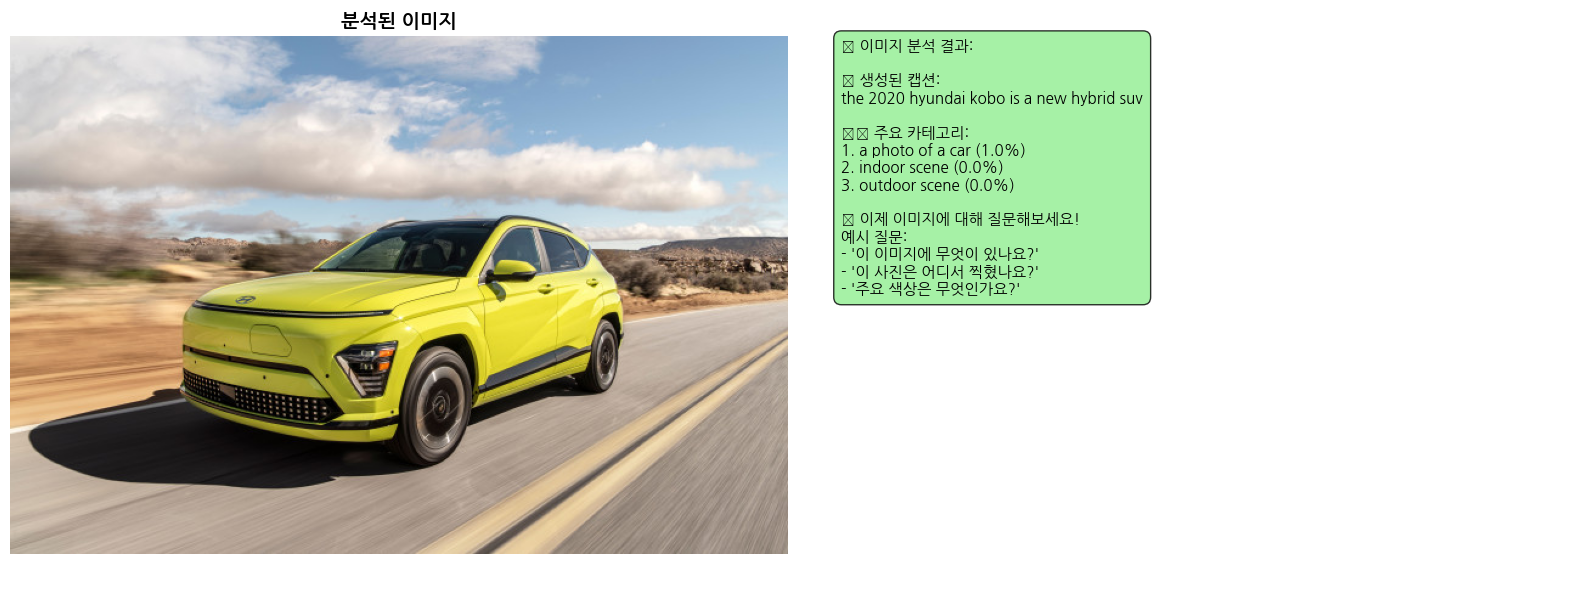

{'caption': 'the 2020 hyundai kobo is a new hybrid suv',
 'categories': [{'category': 'a photo of a car', 'confidence': '1.0%'},
  {'category': 'indoor scene', 'confidence': '0.0%'},
  {'category': 'outdoor scene', 'confidence': '0.0%'}],
 'features': array([[ 1.57269519e-02,  3.53026129e-02, -3.68736684e-02,
         -4.40056771e-02, -1.80542972e-02,  2.23285612e-02,
         -1.11423666e-03, -6.13504928e-03,  1.24559244e-02,
         -3.74245364e-03,  2.62609329e-02,  2.22755075e-02,
          1.08630012e-03,  3.80909559e-03,  9.28405747e-02,
         -4.50930558e-02,  5.85070588e-02, -1.49732968e-02,
         -1.10354330e-02, -2.73539666e-02,  1.71704683e-02,
         -2.37612315e-02,  1.06244124e-02, -5.38331568e-02,
         -3.18186767e-02,  7.88877625e-03, -7.32002081e-03,
         -1.99785363e-02, -4.47611548e-02, -6.22062897e-03,
         -2.63166968e-02, -9.58729461e-02,  2.25649886e-02,
          4.59742434e-02, -1.27179893e-02, -1.16434526e-02,
         -1.05221607e-02, -9.

In [9]:
system.load_and_analyze_image('https://file.newswire.co.kr/data/datafile2/thumb_640/2023/12/1028147215_20231213114838_5550752674.jpg')

In [11]:
system.ask_question('자동차의 움직이는 방식 설명해줘')

❓ 질문: 자동차의 움직이는 방식 설명해줘
💬 답변: 자동차의 움직이는 방식 설명해줘 Answer: 자동차의 움직이는 방식 설명해줘 Answer: 자동차의 움직�


'자동차의 움직이는 방식 설명해줘 Answer: 자동차의 움직이는 방식 설명해줘 Answer: 자동차의 움직�'